# Imports

In [1]:
import pandas as pd 
import numpy as np
import seaborn as sb
import math
import warnings
import matplotlib.pyplot as plt
get_ipython().run_line_magic('matplotlib', 'inline')

from sklearn import preprocessing
from sklearn.preprocessing import PolynomialFeatures
from sklearn import linear_model

#import classification modules
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier

# import regression modules
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import PolynomialFeatures
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import VotingRegressor

#import split methods
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold 
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import StratifiedShuffleSplit

#import performance scores
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve 
from sklearn.metrics import f1_score
from sklearn.metrics import auc
from sklearn.metrics import mean_squared_error, r2_score 
from sklearn.preprocessing import StandardScaler
from sklearn.utils import shuffle

from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler

import arviz
import seaborn as sns
import pymc3 as pm
import scipy.stats as stats
from __future__ import division
import os
import sys
import glob
import logging

%matplotlib inline
%precision 4
plt.style.use('ggplot')
np.random.seed(1234)
_logger = logging.getLogger("theano.gof.compilelock")
_logger.setLevel(logging.ERROR)

warnings.filterwarnings("ignore")
sb.set(color_codes=True, font_scale=1.2)

# need to install xgboost first
# pip install xgboost in conda environment
try:
    from xgboost import XGBClassifier
except:
    print("Failed to import xgboost, make sure you have xgboost installed")
    print("Use following command to install it: pip install xgboost")
    XGBClassifier = None

try:
    import lightgbm as lgb
except:
    print("Failed to import lightgbm, make sure that you have lightgbm installed")
    print("Use following command to install it: conda install -c conda-forge lightgbm")
    lgb = None

#Templates

## Helpers

In [2]:
def load_file(file,type):
  if file.split('.')[-1] == 'xlsx':
    return pd.read_excel(file)
  elif file.split('.')[-1] == 'csv':
    return pd.read_csv(file)

In [3]:
def basic_analysis(df,n):
  print(df.shape)
  print(df.dtypes)
  print(df.head(n))
  print(df.tail(n))

def rename(df,original_name,new_name):
  df.rename({original_name:new_name}, axis="columns", inplace=True)
  return df

def coltype(df, start,end):
  column = list(df)
  for i in range(start,end):
    print(i,df[column[i]].dtypes)

def blanks(df, start,end):
  column = list(df)
  for i in range(start,end):
    print(i,(df[column[i]].isnull().sum()/df.shape[0])*100)


In [7]:
def b_analysis(df):
    print("Shape is:\n", df.shape)
    print("\n Columns are:\n", df.columns)
    print("\n Types are:\n", df.dtypes)
    print("\n Statistical Analysis of Numerical Columns:\n", df.describe())

#string column analysis analysis
def stringcolanalysis(df):
    stringcols = df.select_dtypes(exclude=[np.number, "datetime64"])
    fig = plt.figure(figsize = (8,10))
    for i,col in enumerate(stringcols):
        fig.add_subplot(4,2,i+1)
        fig.savefig('Categorical.png')
        df[col].value_counts().plot(kind = 'bar', color='black' ,fontsize=10)
        plt.tight_layout()
        plt.title(col)

#numerical analysis
def numcolanalysis(df):
    numcols = df.select_dtypes(include=np.number)
    
    # Box plot for numerical columns
    for col in numcols:
        fig = plt.figure(figsize = (5,5))
        sb.boxplot(df[col], color='grey', linewidth=1)
        plt.tight_layout()
        plt.title(col)
        plt.savefig("Numerical.png")
    
    # Lets also plot histograms for these numerical columns
    df.hist(column=list(numcols.columns),bins=25, grid=False, figsize=(15,12),
                 color='#86bf91', zorder=2, rwidth=0.9)
#string analysis
def stringcolanalysis(df):
    stringcols = df.select_dtypes(exclude=[np.number, "datetime64"])
    fig = plt.figure(figsize = (10,30))
    for i,col in enumerate(stringcols):
      fig.add_subplot(9,2,i+1)
      fig.savefig('Categorical' + str(i) + '.png')
      df[col].value_counts().plot(kind = 'bar', color='black' ,fontsize=10)
      plt.tight_layout()
      plt.title(col)

# Perform correlation analysis over numerical columns
def correlation_anlysis(df):
    # NOTE: If label column is non-numeric, 'encode' it before calling this function 
    numcols = df.select_dtypes(include=np.number)
    corr = numcols.corr()
    ax = sb.heatmap(
    corr, 
    vmin=-1, vmax=1, center=0,
    cmap=sb.diverging_palette(20, 220, n=200),
    square=True
    )
    
    ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right')

# Apply label encoding on specified columns
def apply_label_encoding(df, cols=[]):
    le = preprocessing.LabelEncoder()
    for i in cols:
        le.fit(df[i])
        df[i] = le.transform(df[i])
    return df


# One-Hot/dummy encoding on specified columns
def onehotencoding(df):
    df = pd.get_dummies(df)
    return df

# One Hot encoding with Pandas categorical dtype
def onehotencoding_v2(df, cols=[]):
    for col in cols:
        df[col] = pd.Categorical(df[col])
        dfDummies = pd.get_dummies(df[col], prefix = col)
        df = pd.concat([df, dfDummies], axis=1)
        df = df.drop(col, axis=1)
    return df


In [4]:
def strip_characters(df, map):
    for col,col_type in map.items():
      df[col] = df[col].astype(str).str.replace(r'[a-zA-Z!?#,!@$%^&*()]', '').astype(str).str.strip()
      if (col_type == float or col_type == int):
        df[col] = pd.to_numeric(df[col], errors='coerce')
      else:
        df[col] = df[col].astype(col_type)
          
    return df 

def rename_column(df, rename_column_map): # f10
  for col,val in rename_column_map():
        df.rename(col, val)
  return df

def fill_na_vals(df, map):
    for col,val in map.items():
        df[col].fillna(val, inplace=True)
    return df

def cleanup(df, drop_col=[], cols_to_drop_na_rows=[], cols_to_interpolate=[],to_date=[], date_cols=[], to_numeric=[]):
    def drop_col_fn(df, drop_col):
      return df.drop(drop_col, axis=1)

    def drop_useless_rows(df):
        min_threshold = math.ceil(len(df.columns)*0.4)
        df = df.dropna(thresh=min_threshold)
        return df
    
    def drop_na_rows(df, cols_to_drop_na_rows):
        for i in cols_to_drop_na_rows:
            df = df.drop(df[df[i].isnull()].index)
        return df

    def fill_na_interpolate(df, cols_to_interpolate):
        for i in cols_to_interpolate:
            df[i] = df[i].interpolate(method ='linear', limit_direction ='forward')
        return df

    def change_type_to_date(df, to_date):
        for i in to_date:
            df[i] = pd.to_datetime(df[i], errors='coerce')
        return df

    def date_breakdown(df, date_cols=[]):
      if (len(date_cols) == 1):
        df['year'] = pd.DatetimeIndex(df[idx]).year
        df['month'] = pd.DatetimeIndex(df[idx]).month
        df['date'] = pd.DatetimeIndex(df[idx]).date
      else:
        for idx in range(len(date_cols)):
          df['year' + idx+1] = pd.DatetimeIndex(df[idx]).year
          df['month' + idx+1] = pd.DatetimeIndex(df[idx]).month
          df['date' + idx+1] = pd.DatetimeIndex(df[idx]).date

      return df

    def change_type_to_numeric(df, to_numeric):
        for i in to_numeric:
            df[i] = pd.to_numeric(df[i], errors='coerce')
        return df
    
    try:
        df = drop_col_fn(df, drop_col)
        df = drop_useless_rows(df)
        df = drop_na_rows(df, cols_to_drop_na_rows)
        df = fill_na_interpolate(df, cols_to_interpolate)
        df = change_type_to_date(df, to_date)
        df = date_breakdown(df, date_cols)
        df = change_type_to_numeric(df, to_numeric)
        print("df is all cleaned up..")
        return df
    except Exception as e:
        print("Failed to perform cleanup, exception=%s" % str(e))
    finally:
        return df

In [8]:
def Class_Imbalance(df, label_col, method):
  y = df[label_col].copy()
  x = df.drop(label_col,axis=1)

  if method == 'undersampling':  
    
    rus = RandomUnderSampler(random_state=42, replacement=True) 
    x_rus, y_rus = rus.fit_resample(x, y)
    x_updated = pd.DataFrame(x_rus, columns=x.columns)
    y_updated = pd.DataFrame(y_rus, columns=[label_col])
    df_rus = pd.concat([x_updated, y_updated], axis=1)
    print('original dataset shape:', y.shape)
    print('Resample dataset shape', y_rus.shape)
    return df_rus
  
  elif method == 'oversampling':
    ros = RandomOverSampler(random_state=42)
    x_ros, y_ros = ros.fit_resample(x, y)
    x_updated = pd.DataFrame(x_ros, columns=x.columns)
    y_updated = pd.DataFrame(y_ros, columns=[label_col])
    df_ros = pd.concat([x_updated, y_updated], axis=1)
    print('original dataset shape:', y.shape)
    print('Resample dataset shape', y_ros.shape)
    return df_ros

## ML Algorithms

### Classification Algorithms

In [9]:
def LassoRegularization(trainX, testX, trainY, testY, verbose=True, clf=None):
  if not clf:
    clf = Lasso(alpha=0.1,normalize=True, max_iter=1e5)
  clf.fit(trainX , trainY)
  return validationmetrics(clf,testX,testY,verbose=verbose)

def RidgeRegularization(trainX, testX, trainY, testY, verbose=True, clf=None):
  if not clf:
    clf = Ridge(alpha=0.1,normalize=True)
  clf.fit(trainX , trainY)
  return validationmetrics(clf,testX,testY,verbose=verbose)

def LogReg(trainX, testX, trainY, testY, verbose=True, clf=None):
    if not clf:
        clf  = LogisticRegression()
    clf.fit(trainX , trainY)
    return validationmetrics(clf,testX,testY,verbose=verbose)

def KNN(trainX, testX, trainY, testY, verbose=True, clf=None):
    if not clf:
        clf = KNeighborsClassifier()
    clf.fit(trainX , trainY)
    return validationmetrics(clf,testX,testY,verbose=verbose)

def GadientBoosting(trainX, testX, trainY, testY, verbose=True, clf=None):
    if not clf:
        clf = GradientBoostingClassifier()
    clf.fit(trainX , trainY)
    return validationmetrics(clf,testX,testY,verbose=verbose)

def AdaBoost(trainX, testX, trainY, testY, verbose=True, clf=None):
    if not clf:
        clf = AdaBoostClassifier(n_estimators=100, random_state=0)
    clf.fit(trainX , trainY)
    return validationmetrics(clf,testX,testY,verbose=verbose)

def SVM(trainX, testX, trainY, testY, svmtype="SVC", verbose=True, clf=None):
    # for one vs all
    if not clf:
        if svmtype == "Linear":
            clf = svm.LinearSVC()
        else:
            clf = svm.SVC()
    clf.fit(trainX , trainY)
    return validationmetrics(clf,testX,testY,verbose=verbose)

def DecisionTree(trainX, testX, trainY, testY, verbose=True, clf=None):
    if not clf:
        clf = DecisionTreeClassifier()
    clf.fit(trainX , trainY)
    return validationmetrics(clf,testX,testY,verbose=verbose)

def RandomForest(trainX, testX, trainY, testY, verbose=True, clf=None):
    if not clf:
        clf  = RandomForestClassifier()
    clf.fit(trainX , trainY)
    return validationmetrics(clf,testX,testY,verbose=verbose)

def NaiveBayes(trainX, testX, trainY, testY, verbose=True, clf=None):
    if not clf:
        clf = GaussianNB()
    clf.fit(trainX , trainY)
    return validationmetrics(clf,testX,testY,verbose=verbose)

def MultiLayerPerceptron(trainX, testX, trainY, testY, verbose=True, clf=None):
    if not clf:
        clf = MLPClassifier(hidden_layer_sizes=5)
    clf.fit(trainX,trainY)
    return validationmetrics(clf,testX,testY,verbose=verbose)

def XgBoost(trainX, testX, trainY, testY, verbose=True, clf=None):
    if not clf:
        clf = XGBClassifier(random_state=1,learning_rate=0.01)
    clf.fit(trainX,trainY)
    return validationmetrics(clf,testX,testY,verbose=verbose)

def LightGbm(trainX, testX, trainY, testY, verbose=True, clf=None):
    d_train = lgb.Dataset(trainX, label=trainY)
    params = {}
    params['learning_rate'] = 0.003
    params['boosting_type'] = 'gbdt'
    params['objective'] = None
    params['metric'] = 'binary_logloss'
    params['sub_feature'] = 0.5
    params['num_leaves'] = 10
    params['min_data'] = 50
    params['max_depth'] = 10
    clf = lgb.train(params, d_train, 100)
    return validationmetrics(clf,testX,testY,verbose=verbose)

### Regression Algorithms

In [10]:
# Regression Algorithms
def LinearReg(trainX, testX, trainY, testY, verbose=True, clf=None):
    if not clf:
        clf  = LinearRegression()
    clf.fit(trainX , trainY)
    return validationmetrics_reg(clf, testX, testY, verbose=verbose)

def RandomForestReg(trainX, testX, trainY, testY, verbose=True, clf=None):
    if not clf:
        clf = RandomForestRegressor(n_estimators=100)
    clf.fit(trainX , trainY)
    return validationmetrics_reg(clf, testX, testY, verbose=verbose)

def PolynomialReg(trainX, testX, trainY, testY, degree=3, verbose=True, clf=None):
    poly = PolynomialFeatures(degree = degree)
    X_poly = poly.fit_transform(trainX)
    poly.fit(X_poly, trainY)
    if not clf:
        clf = LinearRegression() 
    clf.fit(X_poly, trainY)
    return validationmetrics_reg(clf, poly.fit_transform(testX), testY, verbose=verbose)

def DecisionTreeReg(trainX, testX, trainY, testY, verbose=True, clf=None):
    if not clf:
        clf = DecisionTreeRegressor()
    clf.fit(trainX , trainY)
    return validationmetrics_reg(clf, testX, testY, verbose=verbose)

def GradientBoostingReg(trainX, testX, trainY, testY, verbose=True, clf=None):
    if not clf:
        clf = GradientBoostingRegressor()
    clf.fit(trainX , trainY)
    return validationmetrics_reg(clf, testX, testY, verbose=verbose)

def AdaBooostReg(trainX, testX, trainY, testY, verbose=True, clf=None):
    if not clf:
        clf = AdaBoostRegressor(random_state=0, n_estimators=100)
    clf.fit(trainX , trainY)
    return validationmetrics_reg(clf, testX, testY, verbose=verbose)


### Algorithm Helpers & Validation Metrics

In [13]:
#Train Test Split: splitting manually
def traintestsplit(df, label_col, split=None, random=None):
  #make a copy of the label column and store in y
  y = df[label_col].copy()

  #now delete the original
  X = df.drop(label_col,axis=1)

  if split == None:
    return X, y

  #manual split
  trainX, testX, trainY, testY= train_test_split(X, y, test_size=split, random_state=random)
  return X, y, trainX, testX, trainY, testY

#helper function which only splits into X and y
def XYsplit(df, label_col):
    y = df[label_col].copy()
    X = df.drop(label_col,axis=1)
    return X,y


In [14]:
# CONSTANTS

CLASSIFICATION = 'Classification'
REGRESSION = 'Regression'


In [11]:
# Helper function to provide list of supported algorithms for Regression
def get_supported_algorithms(regularization=True):
  return [
    LinearReg, 
    PolynomialReg, 
    DecisionTreeReg, 
    GradientBoostingReg,
    AdaBooostReg, 
  ]

# Helper function to provide list of classification algorithms to be used for recursive elimination feature selection
def get_supported_algorithms_refs():
  return [
    LogisticRegression, 
    GradientBoostingClassifier, 
    AdaBoostClassifier, 
    DecisionTreeClassifier, 
    RandomForestClassifier
  ]

# Helper function to provide list of regression algorithms to be used for recursive elimination feature selection
def get_supported_reg_algorithms_refs():
  return [
    LinearRegression, 
    RandomForestRegressor, 
    DecisionTreeRegressor, 
    GradientBoostingRegressor, 
    AdaBoostRegressor
  ]

In [12]:
# Validation metrics for classification

def validationmetrics(model, testX, testY, verbose=True):   
    predictions = model.predict(testX)
    
    if model.__class__.__module__.startswith('sklearn.linear_model._coordinate_descent') or model.__class__.__module__.startswith('sklearn.linear_model._ridge') or model.__class__.__module__.startswith('lightgbm'):
      for i in range(0, predictions.shape[0]):
        predictions[i] = 1 if predictions[i] >= 0.5 else 0

    accuracy = accuracy_score(testY, predictions) * 100
    precision = precision_score(testY, predictions, pos_label=None, labels=[0,1]) * 100
    recall = recall_score(testY, predictions, average='weighted',pos_label= None,labels=[0,1]) * 100
    fpr , tpr, _ = roc_curve(testY, predictions)
    auc_val = auc(fpr, tpr)
    f_score = f1_score(testY, predictions)

    if verbose:
        print("Prediction Vector: \n", predictions)
        print("\n Accuracy: \n", accuracy)
        print("\n Precision of event Happening: \n", precision)
        print("\n Recall of event Happening: \n", recall)
        print("\n AUC: \n",auc_val)
        print("\n F-Score:\n", f_score)
        #confusion Matrix
        print("\n Confusion Matrix: \n", confusion_matrix(testY, predictions,labels=[0,1]))
    
    res_map = {
      "accuracy": accuracy,
      "precision": precision,
      "recall": recall,
      "auc_val": auc_val,
      "f_score": f_score,
      "model_obj": model
    }
    
    return res_map

def best_fit_line(x_values,y_values):
  """Returns slope and y-intercept of the best fit line of the values"""

  m = ( (x_values.mean()*y_values.mean() - (x_values*y_values).mean()) /
        (x_values.mean()**2              - (x_values**2).mean()) )

  b = y_values.mean() - m * x_values.mean()

  return m, b

#Validation metrics for Regression algorithms
def validationmetrics_reg(model, testX, testY, verbose=True):
    predictions = model.predict(testX)
    
    r2 = r2_score(testY,predictions)
    r2_adjusted = 1-(1-r2)*(testX.shape[0]-1)/(testX.shape[0]-testX.shape[1]-1)
    mse = mean_squared_error(testY,predictions)
    rmse = math.sqrt(mse)
    
    if verbose:
      print("R-Squared Value: ", r2)
      print("Adjusted R-Squared: ", r2_adjusted)
      print("RMSE: ", rmse)
    
    res_map = {
      "r2": r2,
      "r2_adjusted": r2_adjusted,
      "rmse": rmse}

    return res_map

In [15]:
def run_algorithms(df, label_col, algo_list=get_supported_algorithms(), feature_list=[]):
  """
  Run Algorithms with manual split
  
  """
  # Lets make a copy of dataframe and work on that to be on safe side 
  
  print('algo_list_')
  print(algo_list)

  _df = df.copy()
  
  if feature_list:
    impftrs = feature_list
    impftrs.append(label_col)
    _df = _df[impftrs]
  

  X, y, trainX, testX, trainY, testY = traintestsplit(_df, label_col, split = 0.2)

  algo_model_map = {}
  
  for algo in algo_list:
    print("============ " + algo.__name__ + " ===========")
    res = algo(trainX, testX, trainY, testY)
    algo_model_map[algo.__name__] = res.get("model_obj", None)
    print ("============================== \n")

  return algo_model_map


###Consolidated ML Functions

In [16]:
def ClassificationSpecification(df, label_col, n_components=5):
  X, y, trainX, testX, trainY, testY = traintestsplit(df, label_col, split = 0.2) 
  #Add featue list here
  df2 = df.drop(label_col,axis=1)
  arr = df2.columns.values
  feature_list = list(arr)
  #Also ask what happens if we do reg=true in classification
  results = run_algorithms(df, label_col, feature_list=feature_list, algo_list=get_supported_algorithms(regularization=False))
  return {"selected_features": feature_list, "results": results}  

In [17]:
def RegressionSpecification(df, label_col, n_components=5):
  X, y, trainX, testX, trainY, testY = traintestsplit(df, label_col, split = 0.2)  
  
  df2 = df.drop(label_col,axis=1)
  arr = df2.columns.values
  feature_list = list(arr)
  results = run_algorithms(df, label_col, feature_list=feature_list, algo_list=get_supported_algorithms(regularization=False))
  return {"selected_features": feature_list, "results": results} 

##Bayesian Inference

In [18]:
def data_generator(n, yIntercept, slope):
  x = np.linspace(0, 1, n)
  y = yIntercept*x + slope + np.random.randn(n)
  y_mean = y.mean()
  return x,y,y_mean

In [19]:
#EDA
def analyze_data(x,y):

  print("\n\n")
  plt.scatter (x,y)
  plt.title("Generated Data")
  plt.xlabel("x")
  plt.ylabel("y")
  plt.show()

  #https://medium.com/@szabo.bibor/how-to-create-a-seaborn-correlation-heatmap-in-python-834c0686b88e

  df = pd.DataFrame()
  df['x'] = x
  df['y'] = y
  plt.figure(figsize=(16, 6))
  # define the mask to set the values in the upper triangle to True
  mask = np.triu(np.ones_like(df.corr(), dtype=np.bool))
  heatmap = sns.heatmap(df.corr(), mask=mask, vmin=-1, vmax=1, annot=True, cmap='BrBG')
  heatmap.set_title('Triangle Correlation Heatmap', fontdict={'fontsize':18}, pad=16)
  plt.show()

In [20]:
def calculate_divergent_chains(trace):
  diverging = np.array(trace)
  d = diverging.nonzero()[0].size

  if d == 0:  
    print('Divergent Chains: ' + str(d))
    diverging_percentage = diverging.nonzero()[0].size / len(trace) * 100

    print('Divergent Chains (%):' + str(diverging_percentage))   
    arviz.plot_pair(trace, var_names=['a','b'],  kind='kde', group="posterior",   divergences=True,  colorbar=True, divergences_kwargs={'color': '#FF00FF'})
  
  if d > 0:
    print('Divergent Chains ' + str(d))
    print("Using other prior and likelihood values")
    diverging_percentage = diverging.nonzero()[0].size / len(trace) * 100

    print('Percentage of Divergent Chains: ' + str(diverging_percentage))
    arviz.plot_pair(trace, var_names=['a','b'],  kind='kde', group="posterior",   divergences=True,  colorbar=True, divergences_kwargs={'color': '#FF00FF'})

def normal_regression(iteration, sample, tuning_samples, mcmc_chains, x, y, y_mean, step_func, mu, sd, mu_error, sd_error, start_obj):
  mu_a, mu_b = mu # (eg: mu = [0, 0])
  sd_a, sd_b = sd # (eg: sd = [7, 10])

  with pm.Model() as model:
    a = pm.Normal('a', mu=mu_a, sd=sd_a)
    b = pm.Normal('b', mu=mu_b, sd=sd_b)
    sigma = pm.Normal('sigma', mu = mu_error, sd = sd_error)
    y_est = a*x + b # simple auxiliary variables
    likelihood = pm.Normal('y', mu=y_est, sd=sigma, observed=y)

    if step_func == 1:
      step = pm.NUTS() # Hamiltonian MCMC with No U-Turn Sampler
    if step_func == 2:
      step = pm.Slice()
    if step_func == 3:
      step = pm.Metropolis()
    if step_func == 4:
      step = pm.HamiltonianMC()

    trace = pm.sample(step=pm.NUTS(), start = start_obj)
    # trace = pm.sample(
    #   draws = iteration, 
    #   step = pm.Metropolis(), 
    #   random_seed=123, 
    #   progressbar=True, 
    #   return_inferencedata=True, 
    #   tune = tuning_samples, 
    #   chains = mcmc_chains, 
    #   start = start_obj
    # )


    arviz.plot_trace(trace)
    arviz.plot_posterior(trace, rope_color='#FF00FF')
    print(pm.summary(trace))

    # map_estimate = pm.find_MAP(model=model)
    # print(map_estimate)

    calculate_divergent_chains(trace)
    # Display the total number and percentage of divergent chains
    
  print('returnables')
  print(model)
  print(y)
  print(y_mean)
  print(y_est)
  print(trace)
  return model, y, y_mean, y_est, trace

def linear_regression(regType, iteration, sample, tuning_samples, mcmc_chains, step_func, mu, sd, mu_error, sd_error, x, y, y_mean, start_obj): 
  analyze_data(x,y)

  if (regType == 'normal'):
    return normal_regression(iteration, sample, tuning_samples, mcmc_chains, x, y, y_mean, step_func, mu, sd, mu_error, sd_error, start_obj)

In [21]:
#Create additional data based on the posterior estimated in the above function
def posterior_(model, y, y_mean, y_est, trace):
  with model:

    dictionary = pm.sampling.fast_sample_posterior_predictive(trace, var_names = ('a','b','y'), model= model)
    pred_mean = dictionary['y'].mean()
    print("By using the posterior distribtution of the problem new data is generated")
    print("The original data mean is {0} and newly generated data mean by predicted posterior is {1}".format(y_mean,pred_mean))
    
    if (abs(pred_mean - y_mean) <= 0.5):
      print("\n The newly generated data (from predicted posterior distribution) follows the pdf of the original data\n")
    
    elif (abs(pred_mean - y_mean) > 0.5 and abs(pred_mean-y_mean) < 2):
      print("\n The newly generated data (from predicted posterior distribution) somewhat follows the pdf of original data. However it can be improved")
    
    elif (abs(pred_mean - y_mean) > 2):
      print("\nTry using different prior and likelihood combinations with sound parameter values")

  y_ = dictionary['y'][-1]

  return (y, y_)

#Dataset 1

In [ ]:
!gdown --id "1-tAzvpVwug637sFmV3XnkjM2DYjPrRRV" -O "supermarket_sales.csv"
df2 = load_file("supermarket_sales.csv","csv")

Downloading...
From: https://drive.google.com/uc?id=1-tAzvpVwug637sFmV3XnkjM2DYjPrRRV
To: /content/supermarket_sales.csv
100% 132k/132k [00:00<00:00, 8.08MB/s]


##Data Analysis

Invoice ID                 0
Branch                     0
City                       0
Customer type              0
Gender                     0
Product line               0
Unit price                 0
Quantity                   0
Tax 5%                     0
Total                      0
Date                       0
Time                       0
Payment                    0
cogs                       0
gross margin percentage    0
gross income               0
Rating                     0
dtype: int64

Shape is:
 (1000, 17)

 Columns are:
 Index(['Invoice ID', 'Branch', 'City', 'Customer type', 'Gender',
       'Product line', 'Unit price', 'Quantity', 'Tax 5%', 'Total', 'Date',
       'Time', 'Payment', 'cogs', 'gross margin percentage', 'gross income',
       'Rating'],
      dtype='object')

 Types are:
 Invoice ID                  object
Branch                      object
City                        object
Customer type               object
Gender                      object
Product

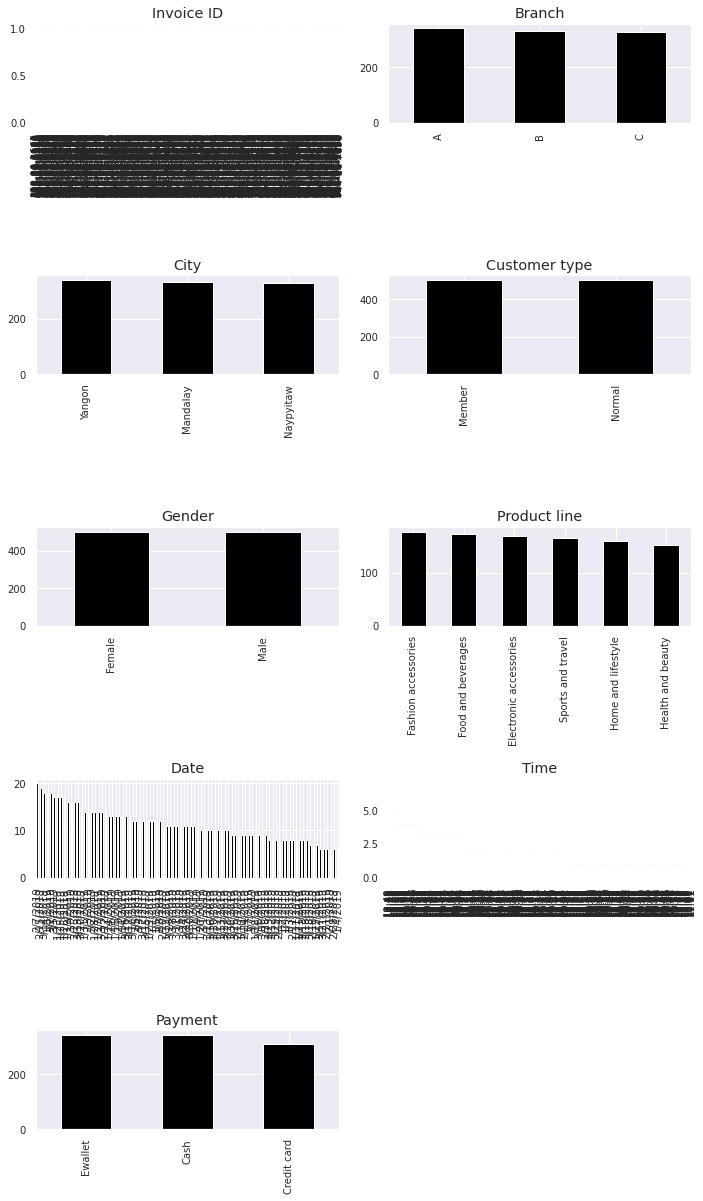

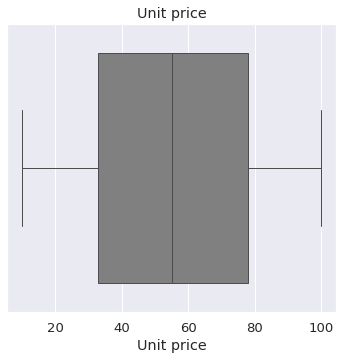

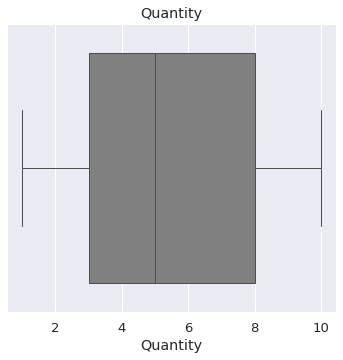

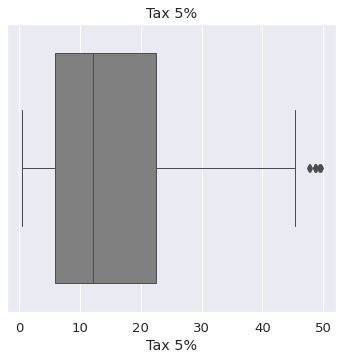

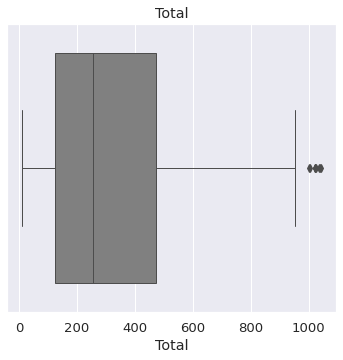

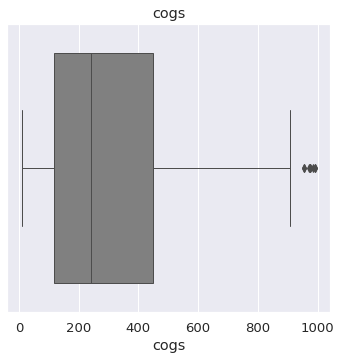

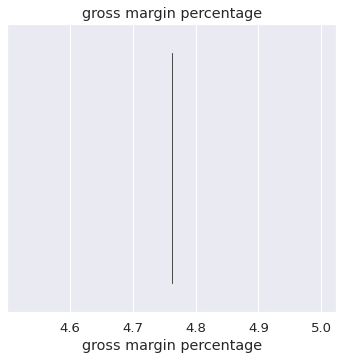

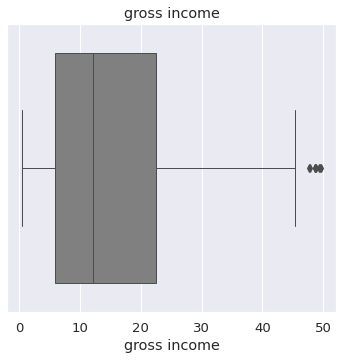

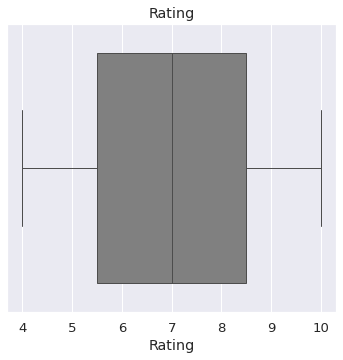

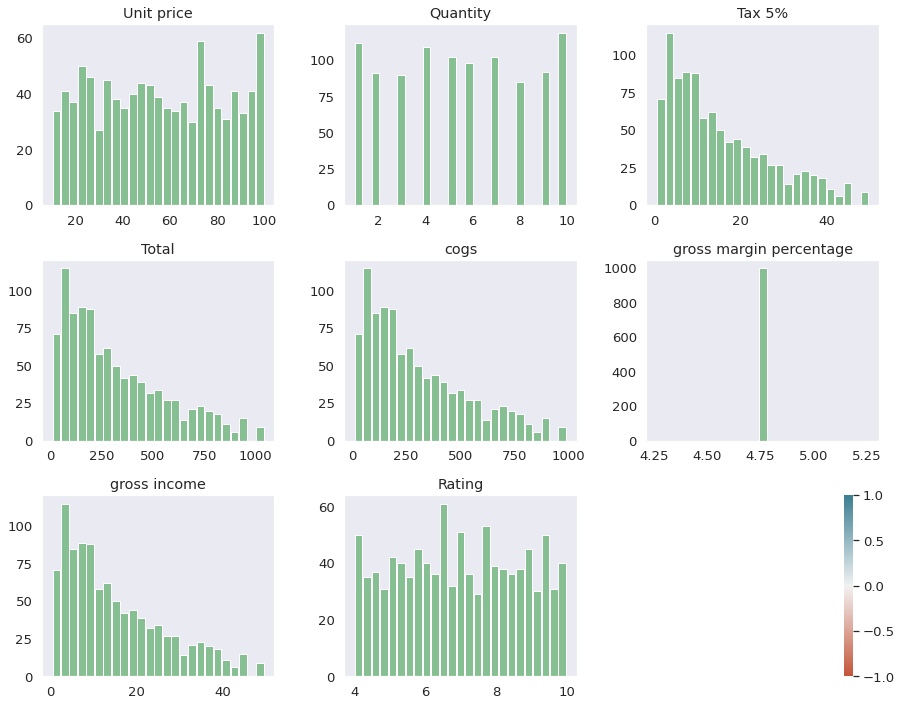

In [ ]:
print(df2.isnull().sum())
print()
b_analysis(df2)
print()
stringcolanalysis(df2)
print()
numcolanalysis(df2)
print()
correlation_anlysis(df2)
print()


In [ ]:
df2

,Invoice ID,Branch,City,Customer type,Gender,Product line,Unit price,Quantity,Tax 5%,Total,Date,Time,Payment,cogs,gross margin percentage,gross income,Rating
0,750-67-8428,A,Yangon,Member,Female,Health and beauty,74.69,7,26.1415,548.9715,1/5/2019,13:08,Ewallet,522.83,4.761905,26.1415,9.1
1,226-31-3081,C,Naypyitaw,Normal,Female,Electronic accessories,15.28,5,3.8200,80.2200,3/8/2019,10:29,Cash,76.40,4.761905,3.8200,9.6
2,631-41-3108,A,Yangon,Normal,Male,Home and lifestyle,46.33,7,16.2155,340.5255,3/3/2019,13:23,Credit card,324.31,4.761905,16.2155,7.4
3,123-19-1176,A,Yangon,Member,Male,Health and beauty,58.22,8,23.2880,489.0480,1/27/2019,20:33,Ewallet,465.76,4.761905,23.2880,8.4
4,373-73-7910,A,Yangon,Normal,Male,Sports and travel,86.31,7,30.2085,634.3785,2/8/2019,10:37,Ewallet,604.17,4.761905,30.2085,5.3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,233-67-5758,C,Naypyitaw,Normal,Male,Health and beauty,40.35,1,2.0175,42.3675,1/29/2019,13:46,Ewallet,40.35,4.761905,2.0175,6.2
996,303-96-2227,B,Mandalay,Normal,Female,Home and lifestyle,97.38,10,48.6900,1022.4900,3/2/2019,17:16,Ewallet,973.80,4.761905,48.6900,4.4
997,727-02-1313,A,Yangon,Member,Male,Food and beverages,31.84,1,1.5920,33.4320,2/9/2019,13:22,Cash,31.84,4.761905,1.5920,7.7
998,347-56-2442,A,Yangon,Normal,Male,Home and lifestyle,65.82,1,3.2910,69.1110,2/22/2019,15:33,Cash,65.82,4.761905,3.2910,4.1


In [ ]:
df2.columns

Index(['Invoice ID', 'Branch', 'City', 'Customer type', 'Gender',
       'Product line', 'Unit price', 'Quantity', 'Tax 5%', 'Total', 'Date',
       'Time', 'Payment', 'cogs', 'gross margin percentage', 'gross income',
       'Rating'],
      dtype='object')

In [ ]:
df2 = cleanup(df2, drop_col=['Invoice ID', 'Date', 'Time'])
print()
df2 = apply_label_encoding(df2, cols=["Branch", "City", "Customer type", "Gender", "Product line", "Payment"])
print()

df is all cleaned up..




In [ ]:
print(df2.isnull().sum())

Branch                     0
City                       0
Customer type              0
Gender                     0
Product line               0
Unit price                 0
Quantity                   0
Tax 5%                     0
Total                      0
Payment                    0
cogs                       0
gross margin percentage    0
gross income               0
Rating                     0
dtype: int64


In [ ]:
b_analysis(df2)

Shape is:
 (1000, 14)

 Columns are:
 Index(['Branch', 'City', 'Customer type', 'Gender', 'Product line',
       'Unit price', 'Quantity', 'Tax 5%', 'Total', 'Payment', 'cogs',
       'gross margin percentage', 'gross income', 'Rating'],
      dtype='object')

 Types are:
 Branch                       int64
City                         int64
Customer type                int64
Gender                       int64
Product line                 int64
Unit price                 float64
Quantity                     int64
Tax 5%                     float64
Total                      float64
Payment                      int64
cogs                       float64
gross margin percentage    float64
gross income               float64
Rating                     float64
dtype: object

 Statistical Analysis of Numerical Columns:
             Branch         City  ...  gross income      Rating
count  1000.000000  1000.000000  ...   1000.000000  1000.00000
mean      0.988000     1.008000  ...     15.379369

##ML Algorithms

In [ ]:
r2 = RegressionSpecification(df2, 'gross income', n_components=4)

algo_list_
[<function LinearReg at 0x7fdf8723c950>, <function PolynomialReg at 0x7fdf8723cb90>, <function DecisionTreeReg at 0x7fdf8723c710>, <function GradientBoostingReg at 0x7fdf8723c830>, <function AdaBooostReg at 0x7fdf8723cef0>]
============ LinearReg ===========
R-Squared Value:  1.0
Adjusted R-Squared:  1.0
RMSE:  4.674638837544446e-15

============ PolynomialReg ===========
R-Squared Value:  1.0
Adjusted R-Squared:  1.0
RMSE:  2.482257101522912e-10

============ DecisionTreeReg ===========
R-Squared Value:  0.9999209283037876
Adjusted R-Squared:  0.9999154017873857
RMSE:  0.10333527955156492

============ GradientBoostingReg ===========
R-Squared Value:  0.9998978153973199
Adjusted R-Squared:  0.999890673462724
RMSE:  0.11747104209045088

============ AdaBooostReg ===========
R-Squared Value:  0.995483575774209
Adjusted R-Squared:  0.9951679117154172
RMSE:  0.7809719851318269



##Bayesian Inference

In [ ]:
Super_X = df2.loc[:,'Unit price']
Super_Y = df2.loc[:,'gross income']
Super_Y_mean = df2["gross income"].mean()

In [ ]:
Super_X

0      74.69
1      15.28
2      46.33
3      58.22
4      86.31
       ...  
995    40.35
996    97.38
997    31.84
998    65.82
999    88.34
Name: Unit price, Length: 1000, dtype: float64

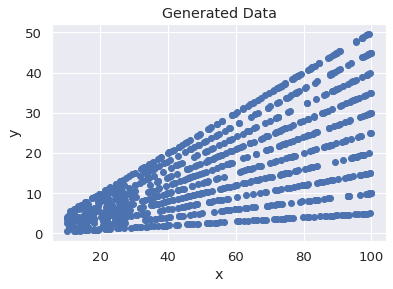

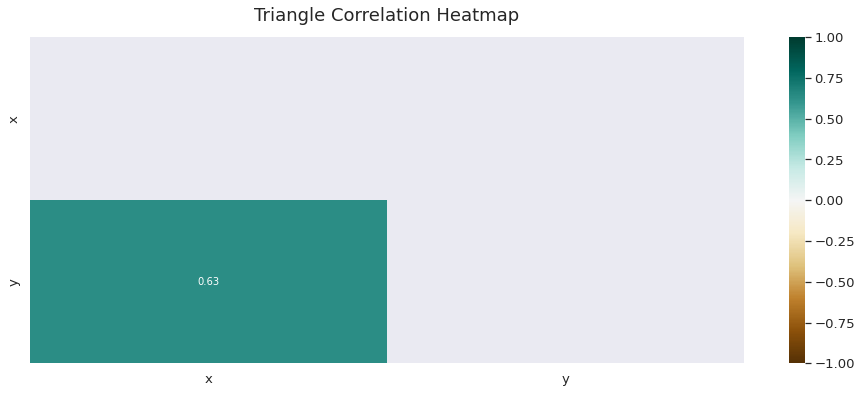

Sequential sampling (2 chains in 1 job)
NUTS: [sigma, b, a]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 6 seconds.


        mean     sd  hdi_3%  hdi_97%  ...  mcse_sd  ess_bulk  ess_tail  r_hat
a      0.280  0.010   0.262    0.300  ...    0.000     839.0     810.0    1.0
b     -0.209  0.624  -1.353    0.980  ...    0.016     839.0     813.0    1.0
sigma  8.743  0.195   8.378    9.092  ...    0.004    1147.0     836.0    1.0

[3 rows x 9 columns]
Divergent Chains 1000
Using other prior and likelihood values
Percentage of Divergent Chains: 100.0
returnables
    a ~ Normal
    b ~ Normal
sigma ~ Normal
    y ~ Normal
0      26.1415
1       3.8200
2      16.2155
3      23.2880
4      30.2085
        ...   
995     2.0175
996    48.6900
997     1.5920
998     3.2910
999    30.9190
Name: gross income, Length: 1000, dtype: float64
15.379369000000002
Elemwise{add,no_inplace}.0
<MultiTrace: 2 chains, 1000 iterations, 3 variables>




By using the posterior distribtution of the problem new data is generated
The original data mean is 15.379369000000002 and newly generated data mean by predicted posterior is 15

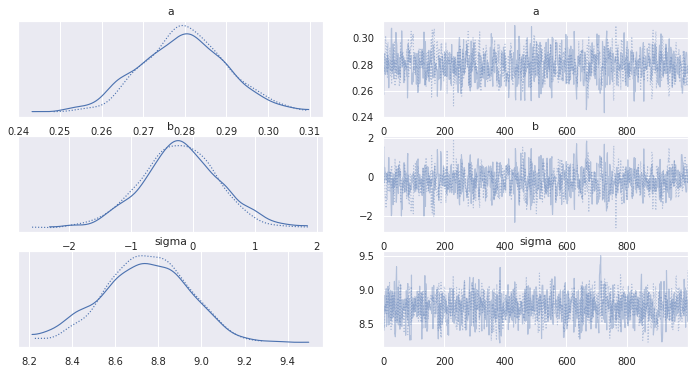

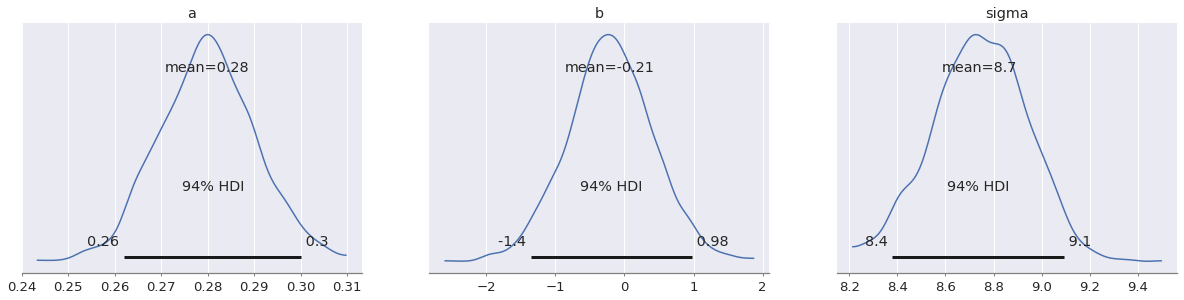

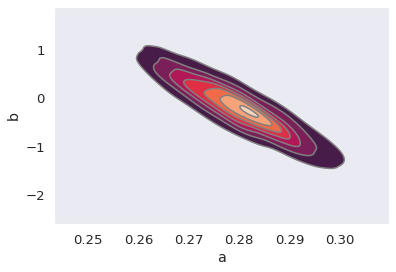

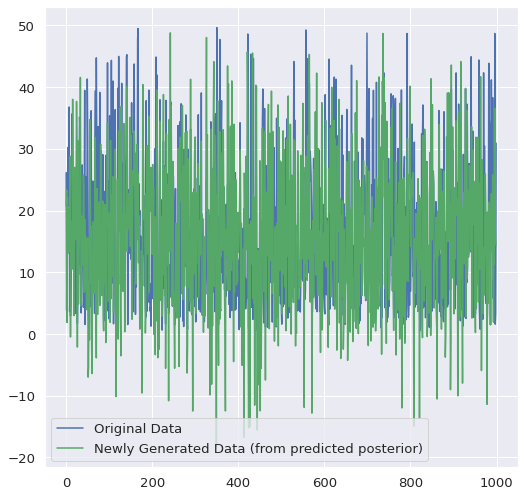

In [ ]:
regTypes = ['normal'] #, 'uniform', 'gamma'
iteration = 100
sample = 100
tuning_samples = 200
mcmc_chains = 3
mu = [15, 15]
sd = [10, 10]
mu_error = 0
sd_error = 1

regType = regTypes[0]
step_func = 1
start_obj = {'a': -0.351, 'b': 16, 'sigma': 11}

model, y, y_mean, y_est, trace = linear_regression(
  regType, 
  iteration, 
  sample,
  tuning_samples, 
  mcmc_chains, 
  step_func, 
  mu, 
  sd, 
  mu_error, 
  sd_error, 
  Super_X, Super_Y, Super_Y_mean, start_obj)

print("\n\n\n")
y, y_ = posterior_(model,y, y_mean,y_est, trace)
print("\n\n\n")

plt.figure(figsize=(100,100))
plt.subplot(10,10,1)
plt.plot(y, label = "Original Data", color = 'b')
plt.plot(y_, label = "Newly Generated Data (from predicted posterior)", color = 'g')
plt.legend()
plt.show()

#Dataset 2

In [35]:
!gdown --id "1NOKvo1Z28HfSuIn7EaMXmKNN7Vge28jQ" -O "saleskaggle3.csv"
df = load_file("saleskaggle3.csv","csv")
df_sales = df.copy()

Downloading...
From: https://drive.google.com/uc?id=1NOKvo1Z28HfSuIn7EaMXmKNN7Vge28jQ
To: /content/saleskaggle3.csv
100% 13.6M/13.6M [00:00<00:00, 43.4MB/s]


##Data Analysis

Order                    0
File_Type                0
SKU_number               0
SoldFlag            122921
SoldCount           122921
MarketingType            0
ReleaseNumber            0
New_Release_Flag         0
StrengthFactor           0
PriceReg                 0
ReleaseYear              0
ItemCount                0
LowUserPrice             0
LowNetPrice              0
dtype: int64

Shape is:
 (198917, 14)

 Columns are:
 Index(['Order', 'File_Type', 'SKU_number', 'SoldFlag', 'SoldCount',
       'MarketingType', 'ReleaseNumber', 'New_Release_Flag', 'StrengthFactor',
       'PriceReg', 'ReleaseYear', 'ItemCount', 'LowUserPrice', 'LowNetPrice'],
      dtype='object')

 Types are:
 Order                 int64
File_Type            object
SKU_number            int64
SoldFlag            float64
SoldCount           float64
MarketingType        object
ReleaseNumber         int64
New_Release_Flag      int64
StrengthFactor      float64
PriceReg            float64
ReleaseYear           int6

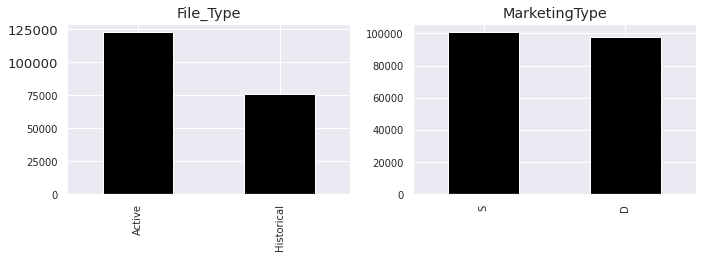

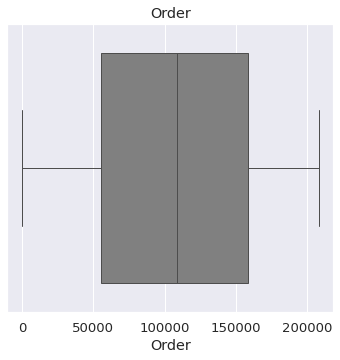

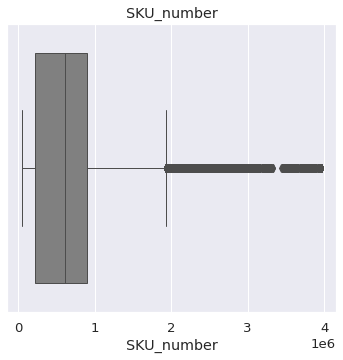

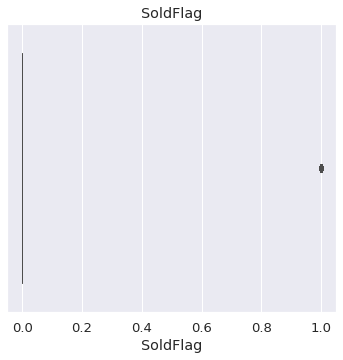

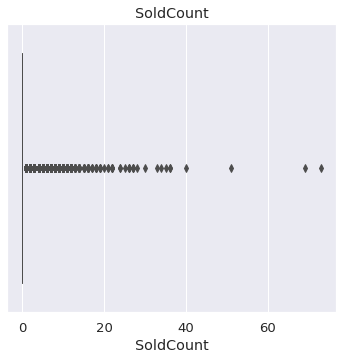

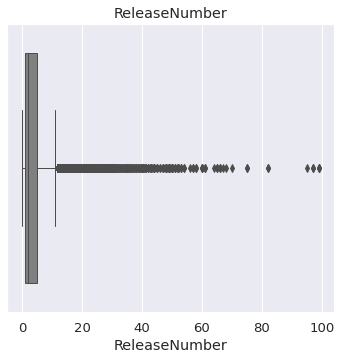

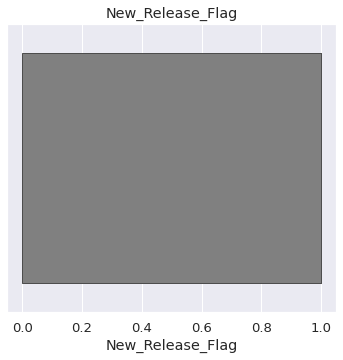

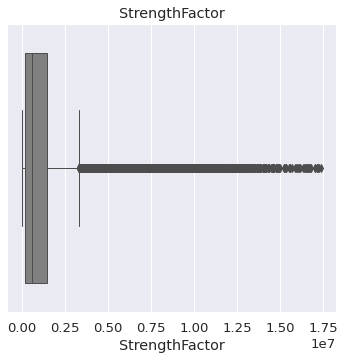

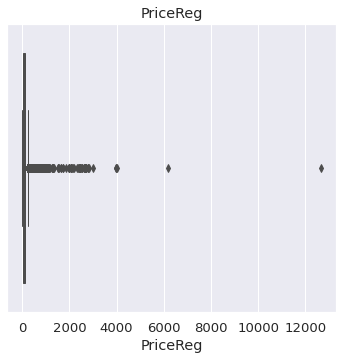

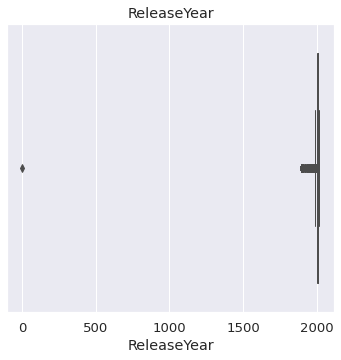

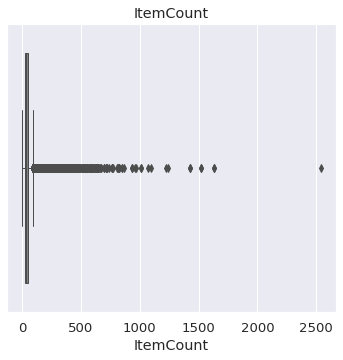

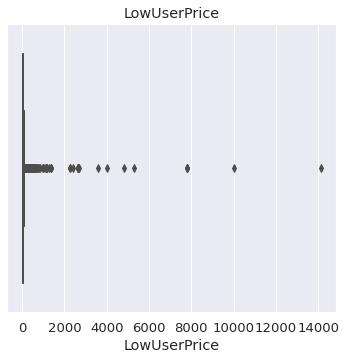

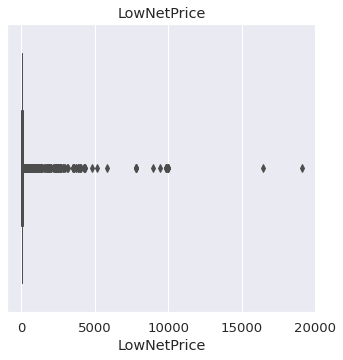

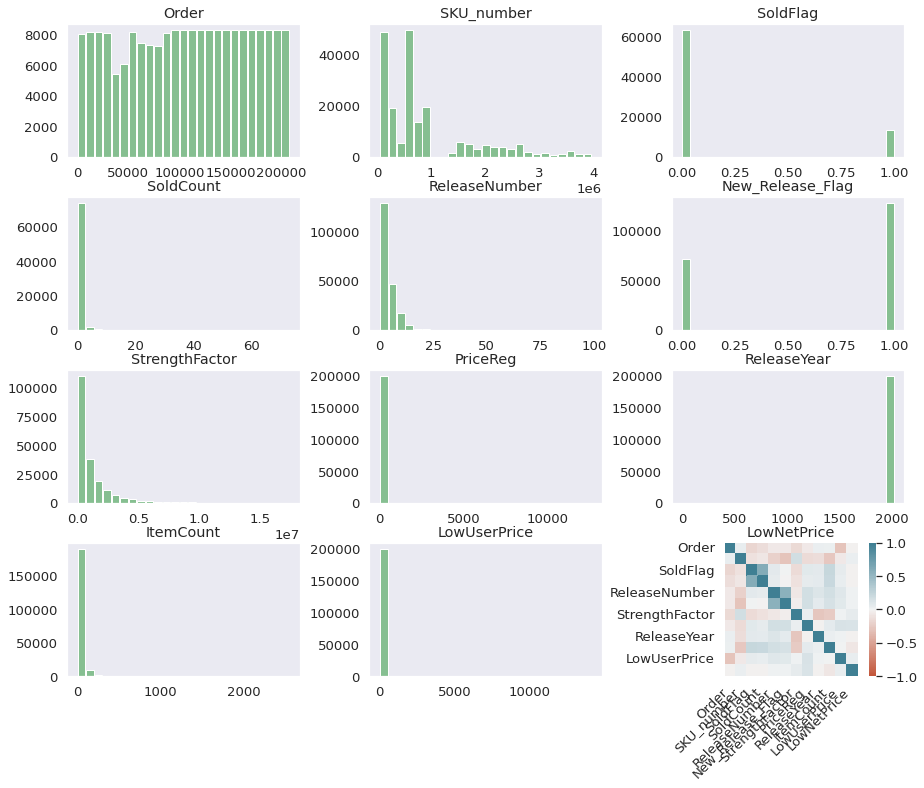

In [ ]:
print(df.isnull().sum())
print()
b_analysis(df)
print()
stringcolanalysis(df)
print()
numcolanalysis(df)
print()
correlation_anlysis(df)
print()


In [36]:
df = cleanup(df, drop_col=['Order', 'SKU_number', 'SoldCount', 'SoldFlag'])
df = apply_label_encoding(df, cols=["File_Type","MarketingType"])

df is all cleaned up..


In [ ]:
print(df.isnull().sum())
b_analysis(df)

File_Type           0
MarketingType       0
ReleaseNumber       0
New_Release_Flag    0
StrengthFactor      0
PriceReg            0
ReleaseYear         0
ItemCount           0
LowUserPrice        0
LowNetPrice         0
dtype: int64
Shape is:
 (198917, 10)

 Columns are:
 Index(['File_Type', 'MarketingType', 'ReleaseNumber', 'New_Release_Flag',
       'StrengthFactor', 'PriceReg', 'ReleaseYear', 'ItemCount',
       'LowUserPrice', 'LowNetPrice'],
      dtype='object')

 Types are:
 File_Type             int64
MarketingType         int64
ReleaseNumber         int64
New_Release_Flag      int64
StrengthFactor      float64
PriceReg            float64
ReleaseYear           int64
ItemCount             int64
LowUserPrice        float64
LowNetPrice         float64
dtype: object

 Statistical Analysis of Numerical Columns:
            File_Type  MarketingType  ...   LowUserPrice    LowNetPrice
count  198917.000000  198917.000000  ...  198917.000000  198917.000000
mean        0.382049       0.50

##ML Algorithms

In [ ]:
r1 = RegressionSpecification(df, 'ItemCount', n_components=4)

algo_list_
[<function LinearReg at 0x7fdf8723c950>, <function PolynomialReg at 0x7fdf8723cb90>, <function DecisionTreeReg at 0x7fdf8723c710>, <function GradientBoostingReg at 0x7fdf8723c830>, <function AdaBooostReg at 0x7fdf8723cef0>]
============ LinearReg ===========
R-Squared Value:  0.1169737854415227
Adjusted R-Squared:  0.11677397561774261
RMSE:  35.61529398781436

============ PolynomialReg ===========
R-Squared Value:  -0.9647408337399832
Adjusted R-Squared:  -0.9756662687025188
RMSE:  53.125419308515596

============ DecisionTreeReg ===========
R-Squared Value:  -0.04651974638779377
Adjusted R-Squared:  -0.04675655127836276
RMSE:  38.772468236922826

============ GradientBoostingReg ===========
R-Squared Value:  0.46005254298370335
Adjusted R-Squared:  0.4599303644974272
RMSE:  27.850018325816674

============ AdaBooostReg ===========
R-Squared Value:  -3.5809886367655093
Adjusted R-Squared:  -3.5820252158807833
RMSE:  81.1202615907096



##Bayesian Inference

In [45]:
Sales_X = df_sales.loc[:,'StrengthFactor']
Sales_Y = df_sales.loc[:,'ItemCount']
Sales_Y_mean = df["ItemCount"].mean()

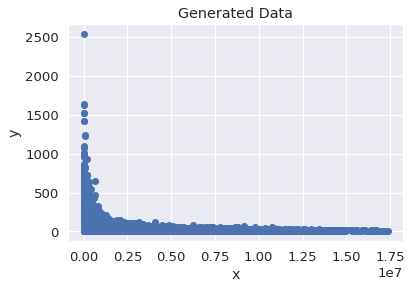

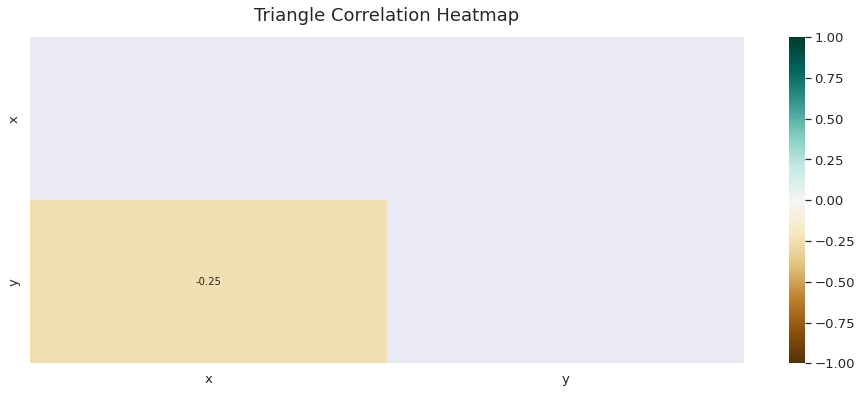

Sequential sampling (2 chains in 1 job)
NUTS: [sigma, b, a]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 996 seconds.


         mean     sd  hdi_3%  hdi_97%  ...  mcse_sd  ess_bulk  ess_tail  r_hat
a      -0.000  0.000  -0.000   -0.000  ...    0.000    1243.0    1657.0    1.0
b      48.295  0.103  48.083   48.483  ...    0.002    1430.0    1187.0    1.0
sigma  36.236  0.058  36.130   36.344  ...    0.001    2022.0    1352.0    1.0

[3 rows x 9 columns]
Divergent Chains 1000
Using other prior and likelihood values
Percentage of Divergent Chains: 100.0
returnables
    a ~ Normal
    b ~ Normal
sigma ~ Normal
    y ~ Normal
0          8
1         39
2         34
3         20
4         28
          ..
198912    54
198913    65
198914    23
198915    23
198916    44
Name: ItemCount, Length: 198917, dtype: int64
41.42628332420055
Elemwise{add,no_inplace}.0
<MultiTrace: 2 chains, 1000 iterations, 3 variables>




By using the posterior distribtution of the problem new data is generated
The original data mean is 41.42628332420055 and newly generated data mean by predicted posterior is 41.425756023338224

 The 

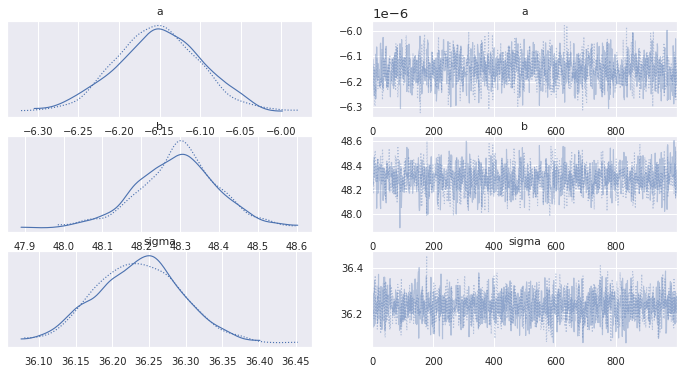

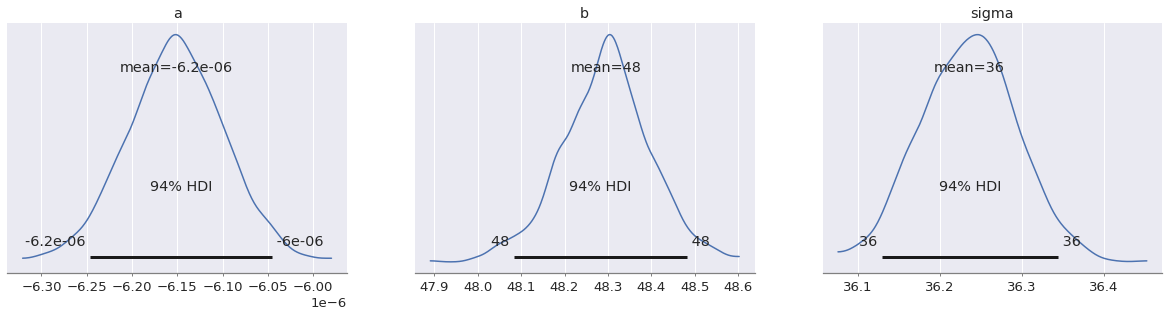

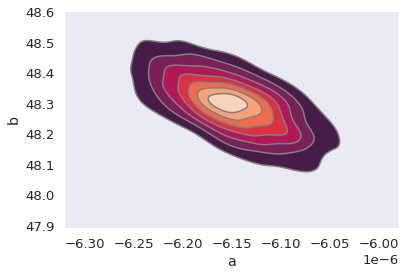

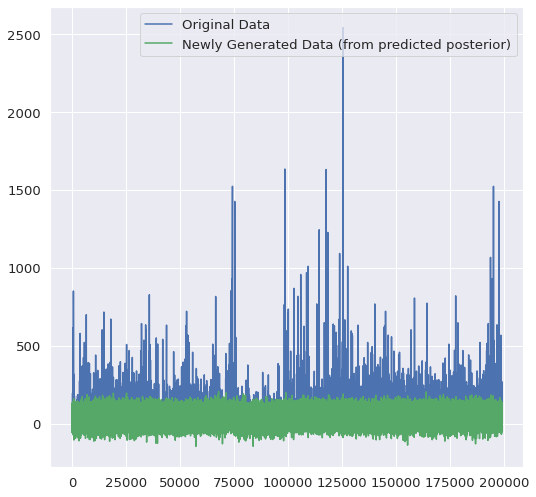

In [46]:
regTypes = ['normal'] #, 'uniform', 'gamma'
iteration = 100
sample = 100
tuning_samples = 200
mcmc_chains = 3
mu = [41, 41]
sd = [10, 10]
mu_error = 0
sd_error = 1

regType = regTypes[0]
step_func = 1
start_obj = {'a': -0.0002, 'b': 48, 'sigma': 36}

model, y, y_mean, y_est, trace = linear_regression(
  regType, 
  iteration, 
  sample,
  tuning_samples, 
  mcmc_chains, 
  step_func, 
  mu, 
  sd, 
  mu_error, 
  sd_error, 
  Sales_X, Sales_Y, Sales_Y_mean, start_obj)

print("\n\n\n")
y, y_ = posterior_(model,y, y_mean,y_est, trace)
print("\n\n\n")

plt.figure(figsize=(100,100))
plt.subplot(10,10,1)
plt.plot(y, label = "Original Data", color = 'b')
plt.plot(y_, label = "Newly Generated Data (from predicted posterior)", color = 'g')
plt.legend()
plt.show()

#Analysis

##Dataset 1


Based on a rule of thumb, it can be said that RMSE values between 0.2 and 0.5 shows that the model can relatively predict the data accurately. As can be seen, from the results of the ML algorithms, only AdaBoost has an RMSE of more than 0.5 while the rest of the algorithms perform very well.
In contrast, teh results from the Bayesian inference seem much more suitable for this dataset as the mean of the original data is 15.379369000000002 and newly generated data has a mean (by predicted posterior) of 15.379042118979159. Hence, the newly generated data (from predicted posterior distribution) follows the pdf of the original data and is a much better technique for this dataset.

##Datset 2

Based on a rule of thumb, it can be said that RMSE values between 0.2 and 0.5 shows that the model can relatively predict the data accurately. As can be seen, from the results of the ML algorithms, none of the algorithms have an RMSE between 0.2 and 0.5, and all the values are very high. Therefore, none of these regression algorithms can be used for prediction of this dataset.

In contrast, the results from the Bayesian inference seem much more suitable for this dataset as the mean of the original data is 41.42628332420055 and newly generated data has a mean (by predicted posterior) of 41.425756023338224. Hence, the newly generated data (from predicted posterior distribution) follows the pdf of the original data and is a much better technique for this dataset. However, looking at the graph comparing the original and the newly generated data, we should still exercise caution using the Bayesian method for prediction here as there is significant difference between the two datasets.